In [4]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage.filters import rank
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation
from skimage import restoration

from sklearn import preprocessing

from scipy import ndimage as ndi

/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.19730941704035873
nucleus/kDNA mean raw intensity 23057.62 12309.861
background+cytoplasm mean raw intensity
6187.1875
nucleus mean normalised intensity 56745.99733664773  kDNA mean normalised intensity  10436.375843394886


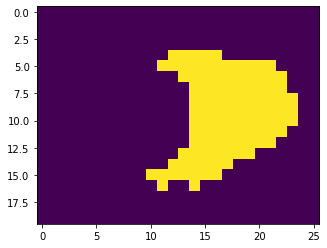

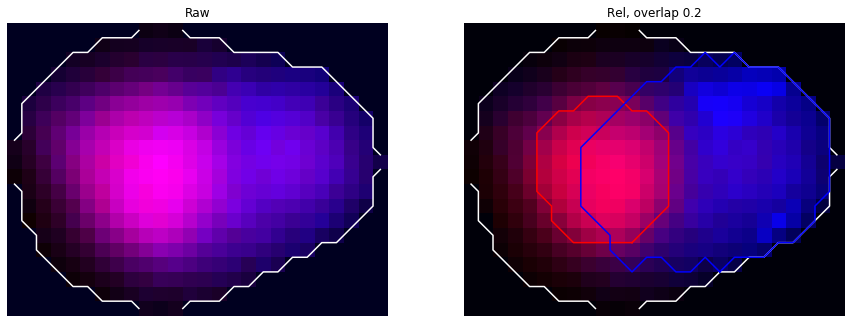

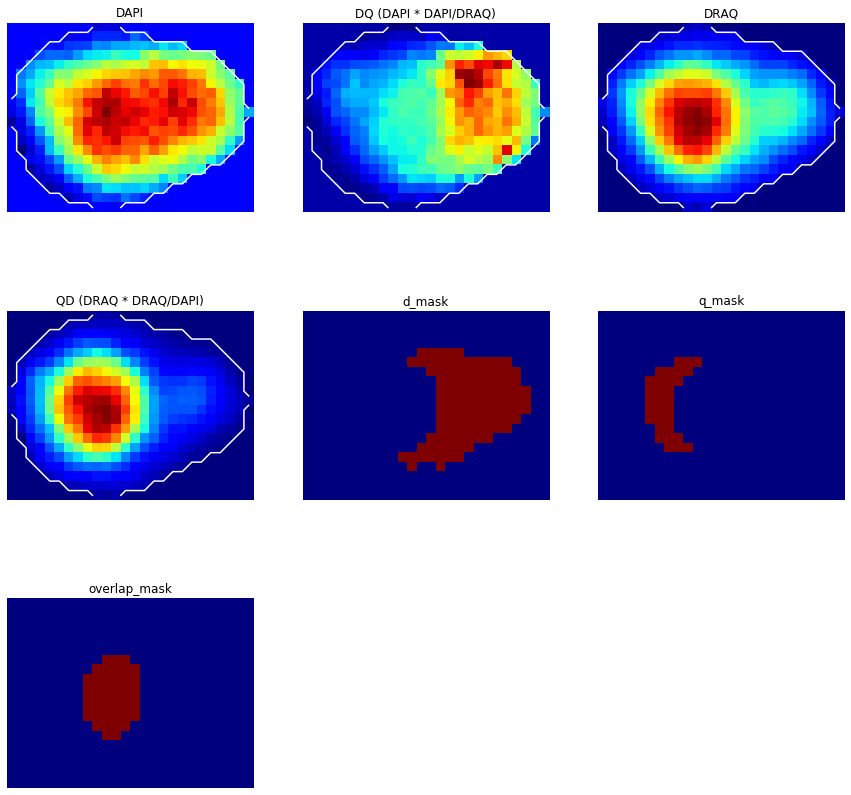

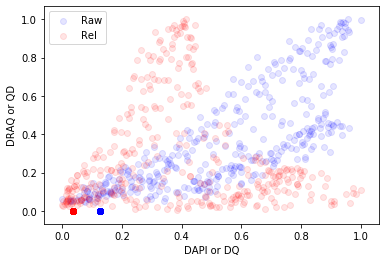

In [14]:
class OneCell():
    def __init__(self, cell_num:int,
                 dapi_img:np.ndarray, draq_img:np.ndarray, trans_img:np.ndarray,
                 cell_mask:np.ndarray,
                 overlap_threshold:float=0.1):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask
        self.cell_contour = measure.find_contours(self.cell_mask, level=0.5)  # mask contour for ctrl images
        self.zeros = np.zeros_like(self.cell_mask)  # zeros image for green channel in RGB images

        self.trans_img = trans_img

        self.dapi_img = np.float32(dapi_img)
        self.dapi_img = self.dapi_img - np.mean(self.dapi_img, where=~self.cell_mask)  # background extraction
        self.dapi_img[~self.cell_mask] = np.mean(self.dapi_img, where=~self.cell_mask)  # extracellular px masking

        self.draq_img = np.float32(draq_img)
        self.draq_img = self.draq_img - np.mean(self.draq_img, where=~self.cell_mask)  # background extraction - NO. (D)
        self.draq_img[~self.cell_mask] = np.mean(self.draq_img, where=~self.cell_mask)  # extracellular px masking

        self.scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), clip=True)  # naive 0-1 scaler, sensitive to outliers
        # self.scaler = preprocessing.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(2.0, 98.0))

        self.dapi_norm = self.scaler.fit_transform(self.dapi_img.reshape(-1,1)).reshape(self.dapi_img.shape)
        self.draq_norm = self.scaler.fit_transform(self.draq_img.reshape(-1,1)).reshape(self.draq_img.shape)   
        self.raw_overlay = np.stack([self.draq_norm, self.zeros, self.dapi_norm], axis=-1)

        self.qd_rel = np.divide(self.draq_norm, self.dapi_norm, out=np.zeros_like(self.draq_norm), where=self.dapi_norm!=0)
        self.qd_rel = filters.median(self.qd_rel)
        self.qd = self.draq_img * self.qd_rel
        self.dq_rel = np.divide(self.dapi_norm, self.draq_norm, out=np.zeros_like(self.dapi_norm), where=self.draq_norm!=0)
        self.dq_rel = filters.median(self.dq_rel)
        self.dq = self.dapi_img * self.dq_rel

        self.qd_norm = self.scaler.fit_transform(self.qd.reshape(-1,1)).reshape(self.qd.shape)
        self.dq_norm = self.scaler.fit_transform(self.dq.reshape(-1,1)).reshape(self.dq.shape)
        self.rel_overlay = np.stack([self.qd_norm, self.zeros, self.dq_norm], axis=-1)

        # plt.imshow(np.digitize(self.draq_norm, bins=filters.threshold_multiotsu(self.draq_norm,classes = 3))) debug plot
        
        #the version that works for 13G - multiotsu with 3 classes for qd_mask
        self.qd_mask = morphology.opening(self.qd_norm > np.max(filters.threshold_multiotsu(self.qd_norm,classes = 3)))
        #plt.imshow(self.qd_mask) #debug plot
        
        self.dq_mask = morphology.opening(self.dq_norm > filters.threshold_otsu(self.dq_norm))       
        #old version
        #self.qd_mask = morphology.opening(self.qd_norm > filters.threshold_otsu(self.qd_norm))
        #self.dq_mask = morphology.opening(self.dq_norm > filters.threshold_otsu(self.dq_norm))

        
        self.q_mask = np.copy(self.qd_mask)
        self.q_mask[self.dq_mask] = False
        self.d_mask = np.zeros_like(self.dq_mask)
        #limiting kDNA mask to only the region that has *some higher than background* staining by DRAQ5 - to avoid incorporation of only-DAPI-stained-background
        self.d_mask[morphology.opening(self.draq_norm > np.unique(filters.threshold_multiotsu(self.draq_norm,classes = 3))[0])] = True 
        self.d_mask[self.qd_mask] = False #OLD
        self.d_mask[~self.dq_mask] = False
        plt.imshow(self.d_mask)

        self.overlap_mask = (self.qd_mask & self.dq_mask)
        #self.overlap_mask = (self.qd_mask & self.dq_mask) #OLD

        self.overlap_percent = np.sum((self.qd_mask & self.dq_mask)) / np.sum((self.qd_mask | self.dq_mask))
        
        
        #mean intensity of bg+cyt; counted before the overlapped masks get cut down
        self.no_feature = np.copy(self.draq_img)
        self.no_feature[self.q_mask.astype(np.bool)] = 0
        self.no_feature[self.d_mask.astype(np.bool)] = 0
        #print(np.mean(self.draq_img)) # -- control that bg+cyt are not taken into account! (uncomment for debug)
        #print(np.mean(self.no_feature)) # -- control that features are not taken into account! (uncomment for debug)
        #plt.imshow(self.no_feature) #debug plot
        print(self.overlap_percent)
        if self.overlap_percent <= 0.5 and self.overlap_percent >= 0.1 :
            self.if_overlapped = "TRUE"
            
            #cutting kDNA and nucleus masks to only non-overlap area
            self.d_mask[self.overlap_mask] = False
            self.q_mask[self.overlap_mask] = False
            ##now all same as before
            self.nucleus_raw_int = np.mean(self.draq_img, where=self.q_mask > 0)
            self.k_raw_int = np.mean(self.draq_img, where=self.d_mask > 0)
                ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise mean intensity of nucleus and kDNA
            self.nucleus_norm_int = self.nucleus_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
            self.k_norm_int = self.k_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
            #Assuming that the intensity of kDNA and nucleus are proportional to those of non-overlapped areas multiplied by the fraction of area that overlaps
            self.d_coefficient = np.sum(self.d_mask)/np.sum(self.overlap_mask)
            self.q_coefficient = np.sum(self.q_mask)/np.sum(self.overlap_mask)
            self.nucleus_norm_int = self.nucleus_norm_int + self.nucleus_norm_int*self.d_coefficient
            self.k_norm_int = self.k_norm_int + self.k_norm_int*self.q_coefficient
            
        if self.overlap_percent <= 0.1:
            self.if_overlapped = "FALSE"
            
            self.nucleus_raw_int = np.mean(self.draq_img, where=self.q_mask > 0)
            self.k_raw_int = np.mean(self.draq_img, where=self.d_mask > 0)
                ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise mean intensity of nucleus and kDNA
            self.nucleus_norm_int = self.nucleus_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
            self.k_norm_int = self.k_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
        
        if self.overlap_percent > 0.5:
            self.if_overlapped = "TRUE"
            self.nucleus_raw_int = 0
            self.k_raw_int = 0
                ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise mean intensity of nucleus and kDNA
            self.nucleus_norm_int = 0
            self.k_norm_int = 0
            
        print('nucleus/kDNA mean raw intensity' , self.nucleus_raw_int , self.k_raw_int)
        print('background+cytoplasm mean raw intensity')
        print(np.mean(self.no_feature, where=self.no_feature > 0))
        print('nucleus mean normalised intensity', self.nucleus_norm_int , ' kDNA mean normalised intensity ', self.k_norm_int)
    
    

    def pic_3d(self):
        xx, yy = np.mgrid[0:self.cell_mask.shape[0], 0:self.cell_mask.shape[1]]

        import plotly.graph_objects as go
        from plotly.offline import iplot

        data = [go.Surface(x=xx,y=yy,z=self.draq_norm,
                        colorscale='Reds', opacity=0.65, showscale=False),
                go.Surface(x=xx,y=yy,z=self.dapi_norm,
                        colorscale='Blues', opacity=0.65, showscale=False)]
        iplot(data)


    def pic_grid(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(334)
        ax0.imshow(self.qd_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('QD (DRAQ * DRAQ/DAPI)')
        ax0.axis('off')

        ax2 = plt.subplot(333)
        ax2.imshow(self.draq_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax2.set_title('DRAQ')
        ax2.axis('off')

        ax1 = plt.subplot(332)
        ax1.imshow(self.dq_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax1.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax1.set_title('DQ (DAPI * DAPI/DRAQ)')
        ax1.axis('off')

        ax3 = plt.subplot(331)
        ax3.imshow(self.dapi_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax3.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax3.set_title('DAPI')
        ax3.axis('off')
        
        ax4 = plt.subplot(335)
        ax4.imshow(self.d_mask, cmap='jet')
        ax4.set_title('d_mask')
        ax4.axis('off')
                
        ax4 = plt.subplot(336)
        ax4.imshow(self.q_mask, cmap='jet')
        ax4.set_title('q_mask')
        ax4.axis('off')
        
        ax5 = plt.subplot(337)
        ax5.imshow(self.overlap_mask, cmap='jet')
        ax5.set_title('overlap_mask')
        ax5.axis('off')
        
        plt.show()


    def pic_overlay(self):
        self.qd_contour = measure.find_contours(self.qd_mask, level=0.5)
        self.dq_contour = measure.find_contours(self.dq_mask, level=0.5)

        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(121)
        ax0.imshow(self.raw_overlay)
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('Raw')
        ax0.axis('off')

        ax2 = plt.subplot(122)
        ax2.imshow(self.rel_overlay)
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        for qd_c in self.qd_contour:
            ax2.plot(qd_c[:, 1], qd_c[:, 0], linewidth=1.5, color='r')
        for dq_c in self.dq_contour:
            ax2.plot(dq_c[:, 1], dq_c[:, 0], linewidth=1.5, color='b')
        ax2.set_title(f'Rel, overlap {round(self.overlap_percent, 2)}')
        ax2.axis('off')

    
    def pic_px_plot(self):
        plt.scatter(self.dapi_norm.ravel(), self.draq_norm.ravel(),
            color='b', alpha=.1, label='Raw')
        plt.scatter(self.dq_norm.ravel(), self.qd_norm.ravel(),
                    color='r', alpha=.1, label='Rel')
        plt.xlabel('DAPI or DQ')
        plt.ylabel('DRAQ or QD')
        plt.legend()
        plt.show()


for region in measure.regionprops(cells_labels):
    if region.label == 1:  # 9, 10
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
        demo_cell = OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_fluo_mask[minr:maxr, minc:maxc])
        
demo_cell.pic_overlay()
demo_cell.pic_grid()
demo_cell.pic_px_plot()

In [16]:
list_of_tiffs = os.listdir('/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023')
print(list_of_tiffs[0])

np.isin(np.array(list_of_tiffs), np.array('thickstack'))

list_of_tiffs_annotated = [s for s in list_of_tiffs if 'thickstack' in s]
list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if '13G' in s]
#list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if 'slice' not in s]
#list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if 'thinstack' not in s]
print(len(list_of_tiffs_annotated))

#list_of_tiffs_annotated = list_of_tiffs_annotated[29:34]
print(list_of_tiffs_annotated)

13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-06(12).tif
10
['13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-06(12).tif', '13G_Capsa_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-02.tif', '13G_Capsa_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-09.tif', '13G_Capsa_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-14.tif', '13G_Capsa_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-18.tif', '13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-05(10).tif', '13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-06(10).tif', '13G_Srosetta_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-07.tif', '13G_Srosetta_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-17.tif', '13G_Srosetta_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-24.tif']


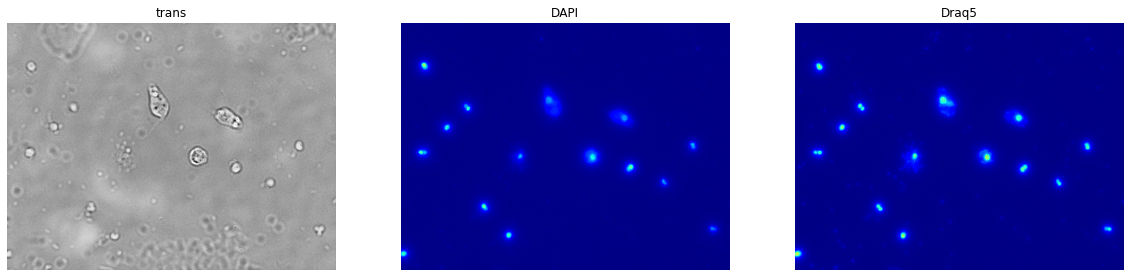

/home/dzavadska/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. 

0.09748427672955975
nucleus/kDNA mean raw intensity 42234.047 30530.45
background+cytoplasm mean raw intensity
6955.652
nucleus mean normalised intensity 35278.395  kDNA mean normalised intensity  23574.797


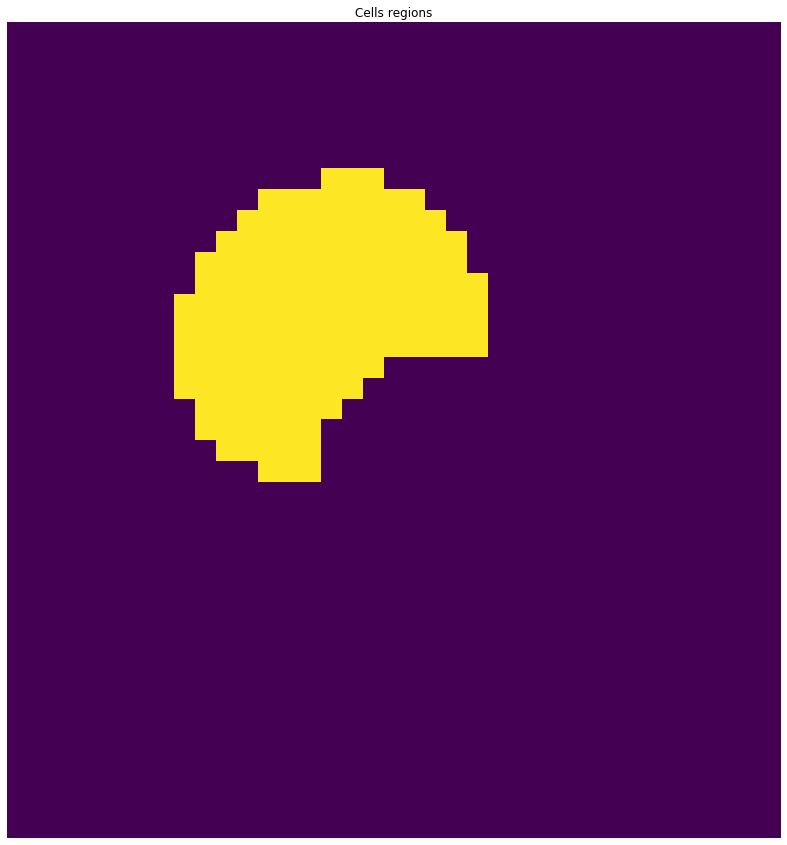

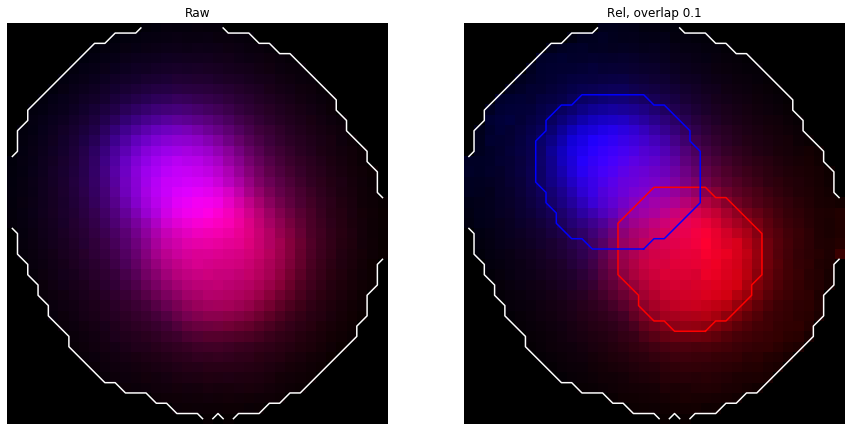

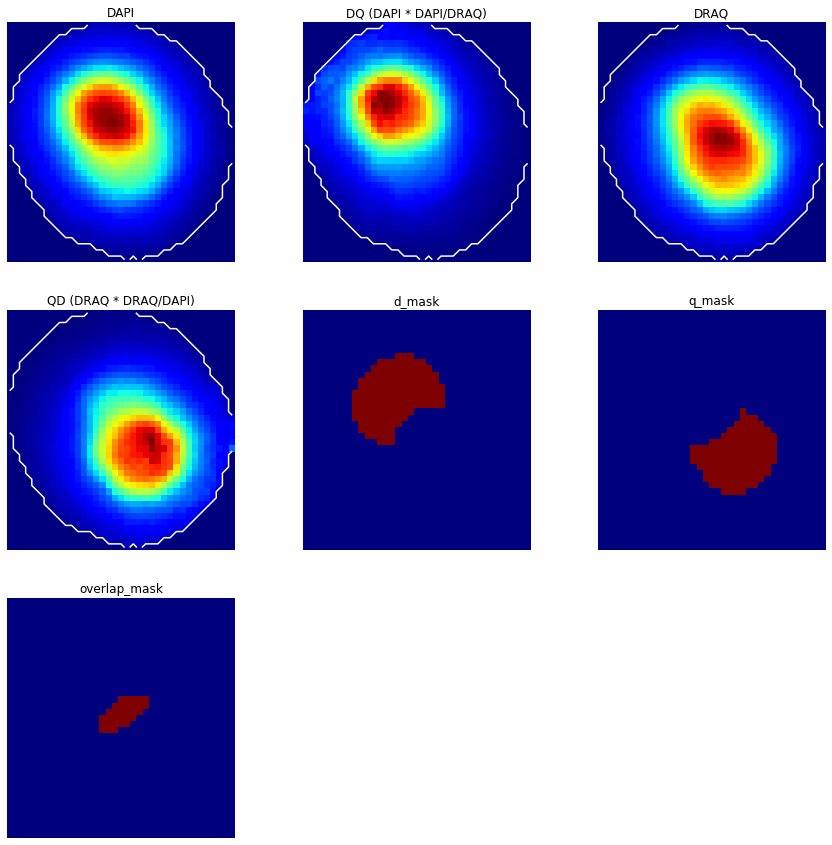

T/C/S:   T


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.23680587425424507
nucleus/kDNA mean raw intensity 26102.062 15717.446
background+cytoplasm mean raw intensity
15803.086
nucleus mean normalised intensity 38900.59170603198  kDNA mean normalised intensity  -99.58098655523256


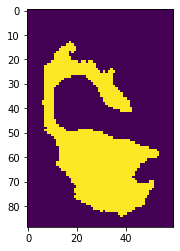

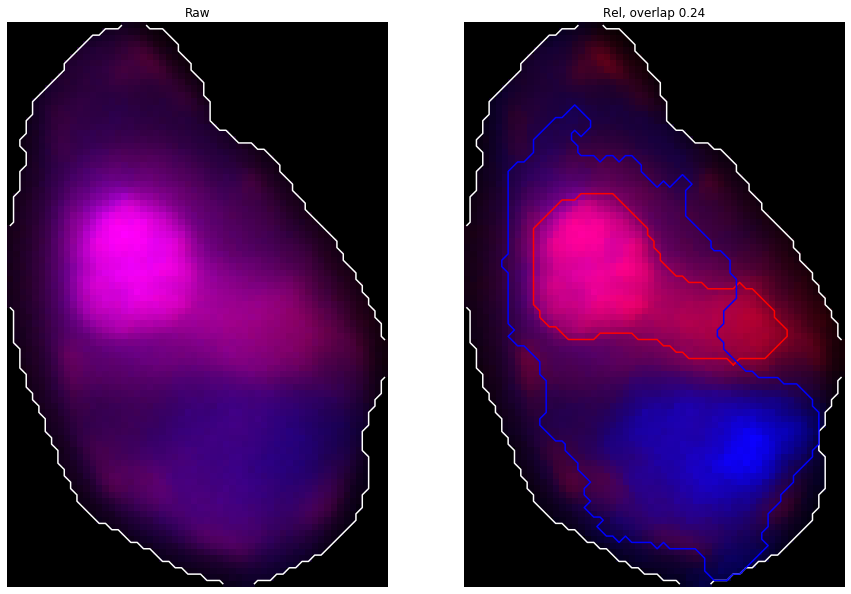

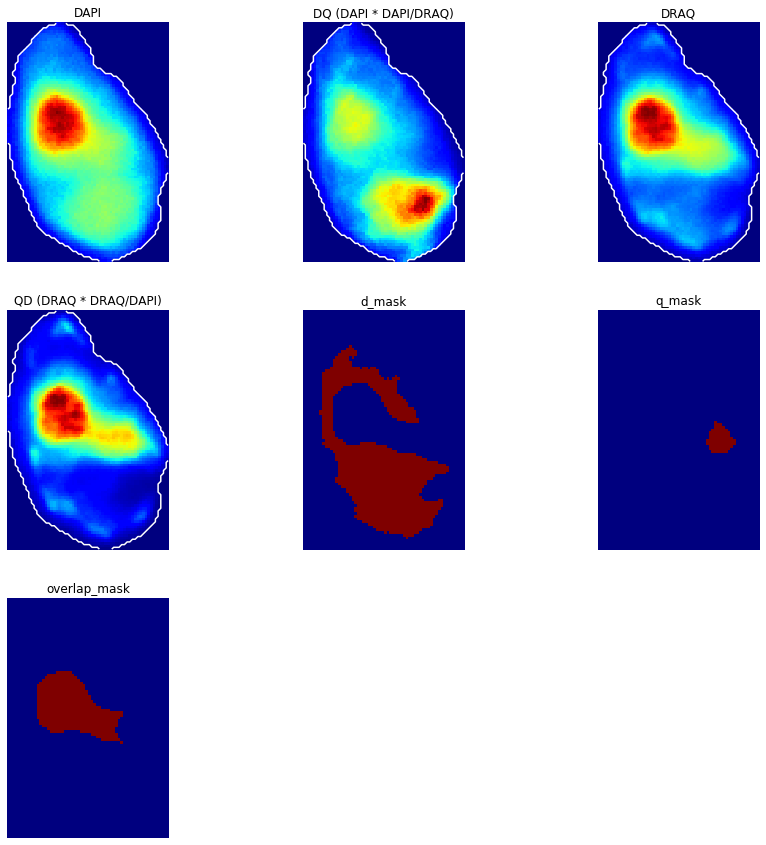

T/C/S:   C


0.0
nucleus/kDNA mean raw intensity 43217.973 33439.86
background+cytoplasm mean raw intensity
9336.759
nucleus mean normalised intensity 33881.215  kDNA mean normalised intensity  24103.102


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


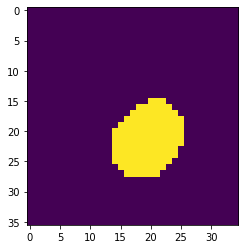

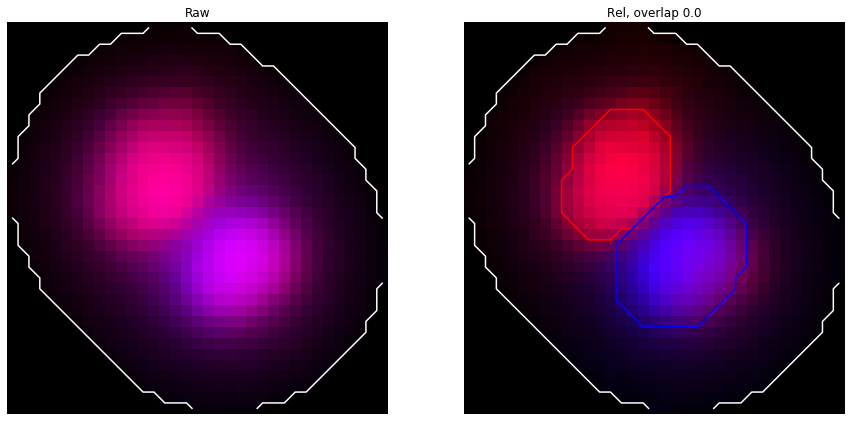

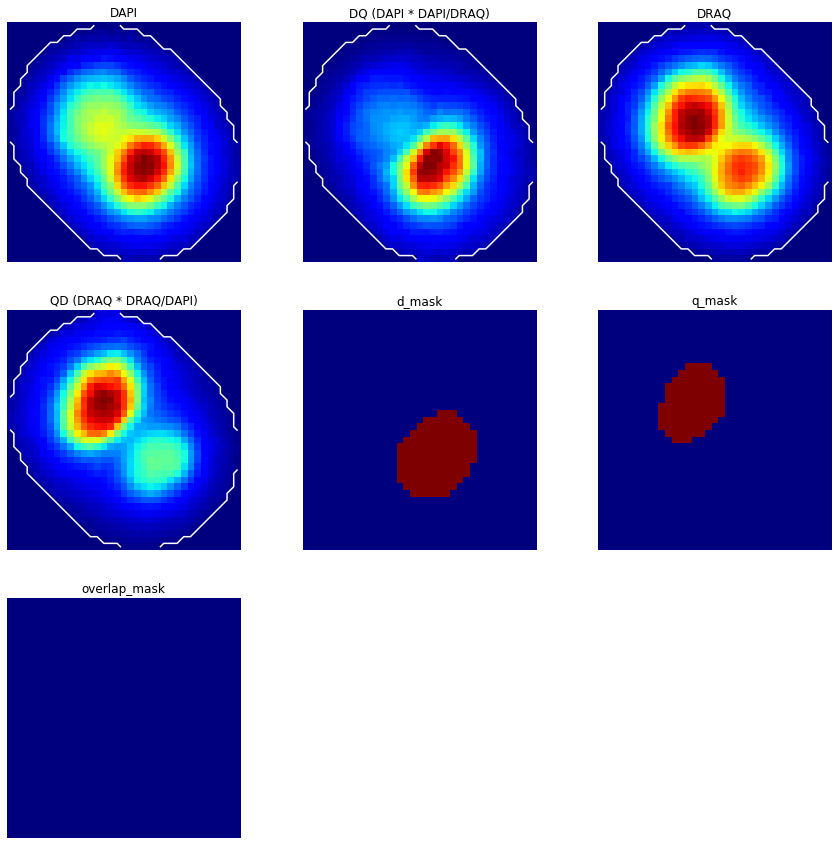

T/C/S:   T


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0
/home/dzavadska/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:343

0.18222794591113972
nucleus/kDNA mean raw intensity nan 12306.036
background+cytoplasm mean raw intensity
14149.697
nucleus mean normalised intensity nan  kDNA mean normalised intensity  -1843.6611328125


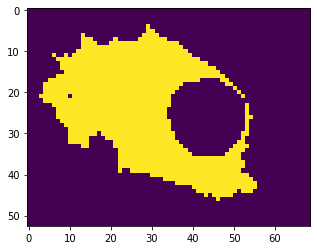

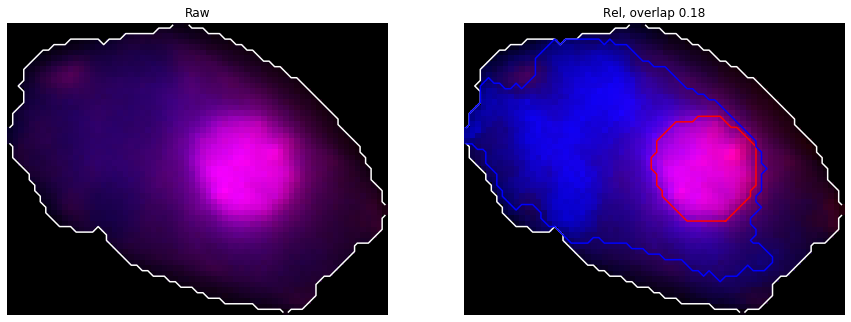

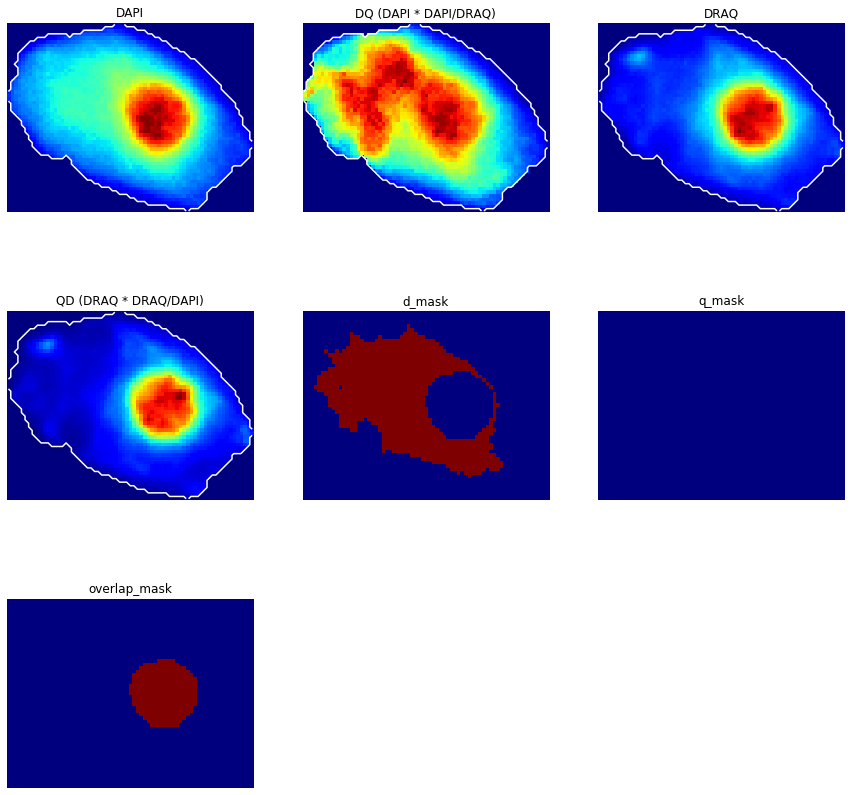

T/C/S:   c


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.14855072463768115
nucleus/kDNA mean raw intensity 40341.758 25682.07
background+cytoplasm mean raw intensity
7083.1055
nucleus mean normalised intensity 132223.4227324695  kDNA mean normalised intensity  53982.36137576219


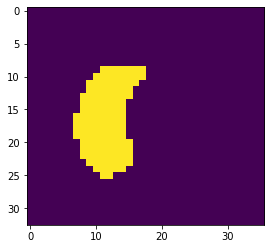

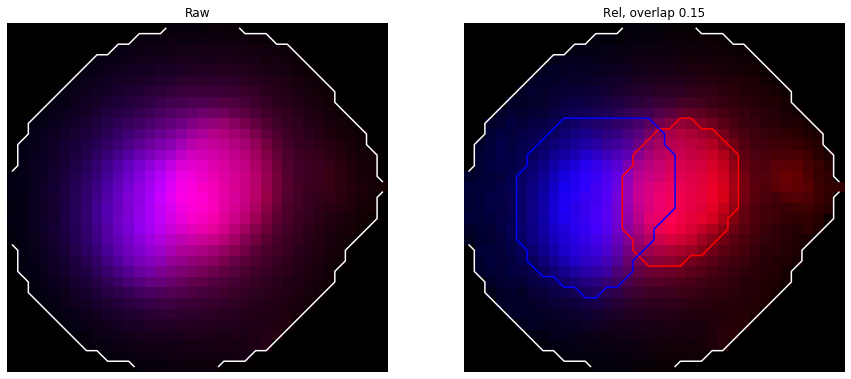

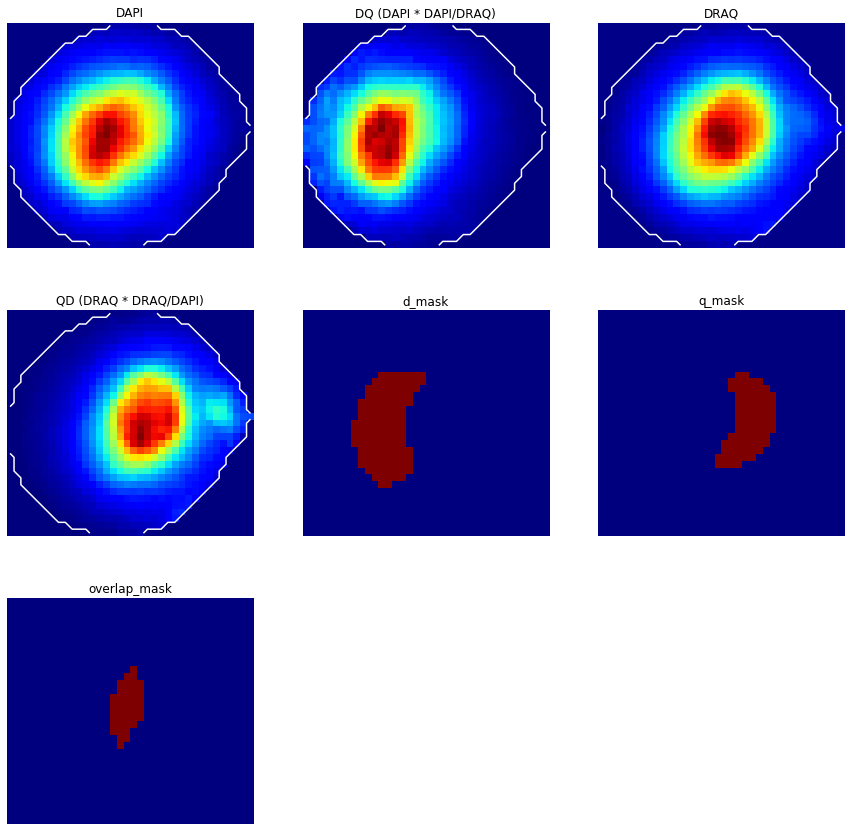

T/C/S:   T


0.25704225352112675
nucleus/kDNA mean raw intensity 33354.61 25691.984
background+cytoplasm mean raw intensity
8169.7
nucleus mean normalised intensity 81419.70954623289  kDNA mean normalised intensity  27603.599903681505


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


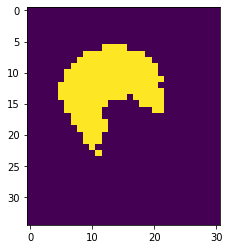

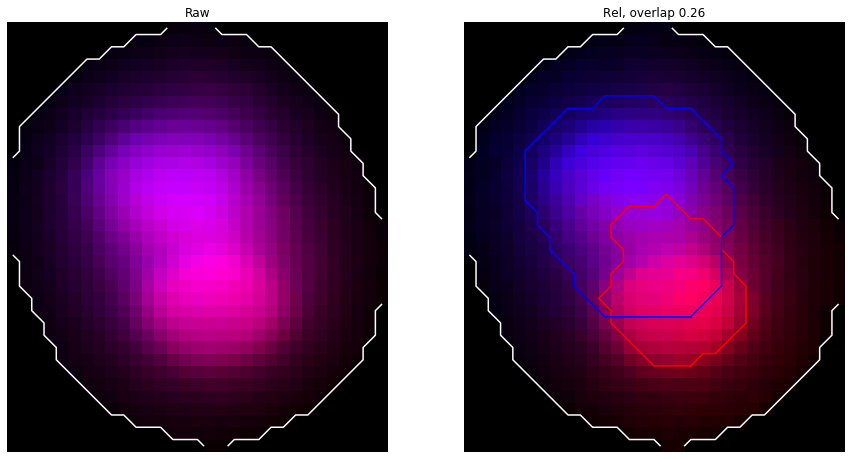

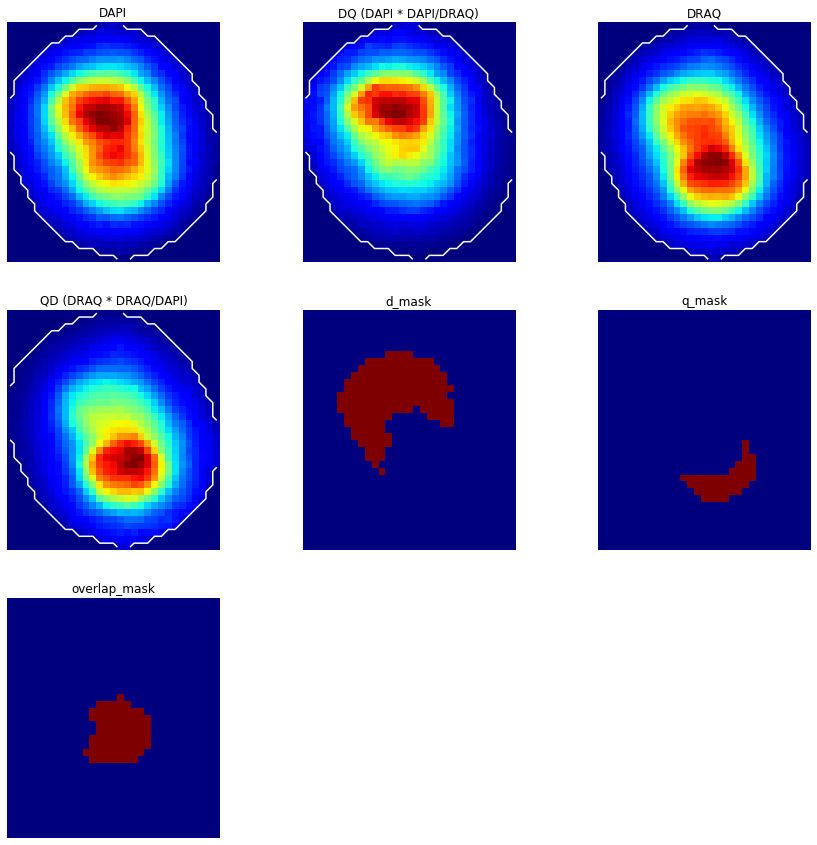

T/C/S:   S


fuck it
0.1817427385892116
nucleus/kDNA mean raw intensity nan 21304.654
background+cytoplasm mean raw intensity
9921.147
nucleus mean normalised intensity nan  kDNA mean normalised intensity  11383.5068359375


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0
/home/dzavadska/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:343

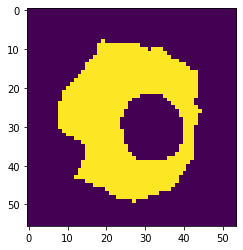

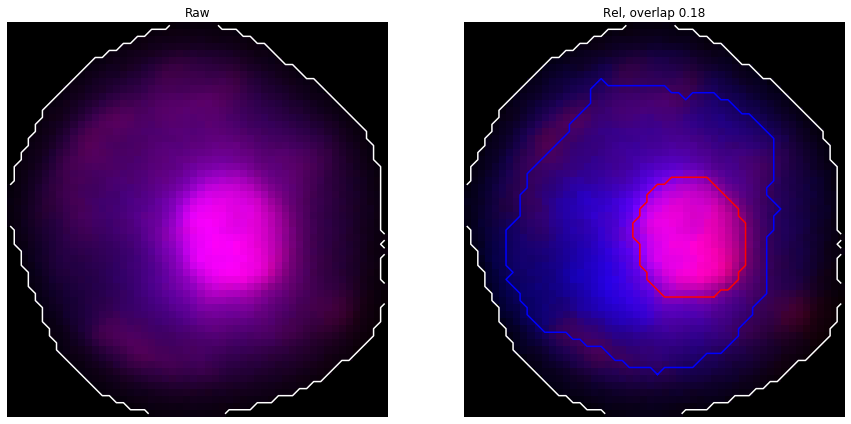

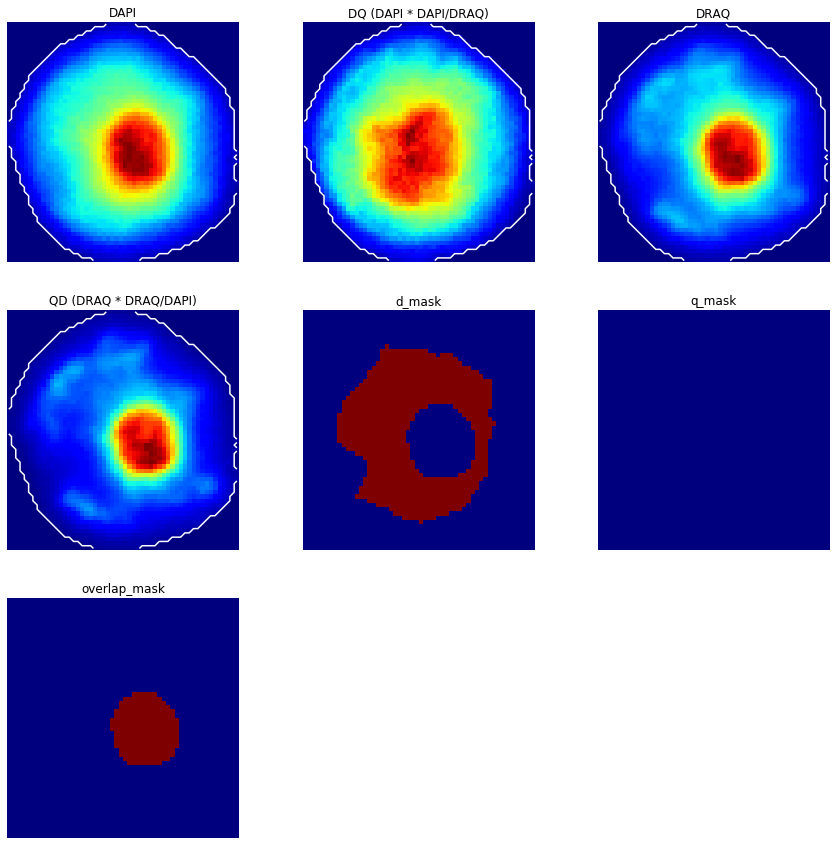

T/C/S:   C


0.009375
nucleus/kDNA mean raw intensity 37912.17 26257.37
background+cytoplasm mean raw intensity
7694.728
nucleus mean normalised intensity 30217.443  kDNA mean normalised intensity  18562.64


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


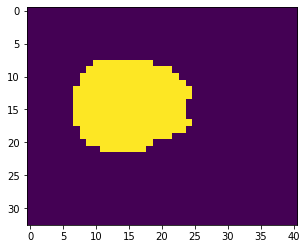

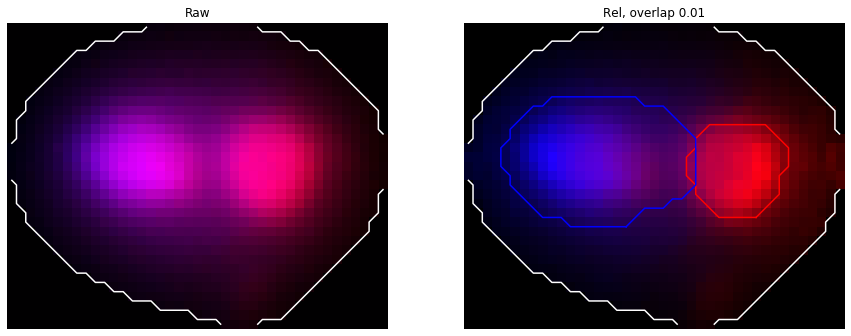

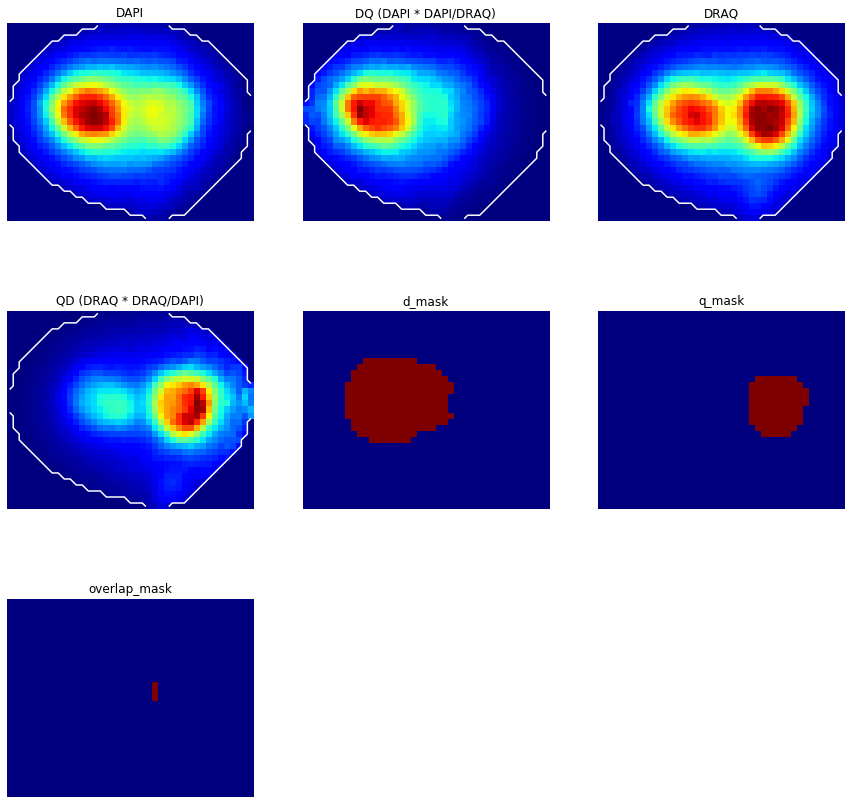

T/C/S:   T


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.39603960396039606
nucleus/kDNA mean raw intensity 24541.115 18522.682
background+cytoplasm mean raw intensity
10899.794
nucleus mean normalised intensity 30920.328255208333  kDNA mean normalised intensity  9592.13368326823


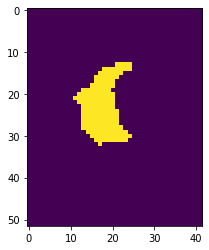

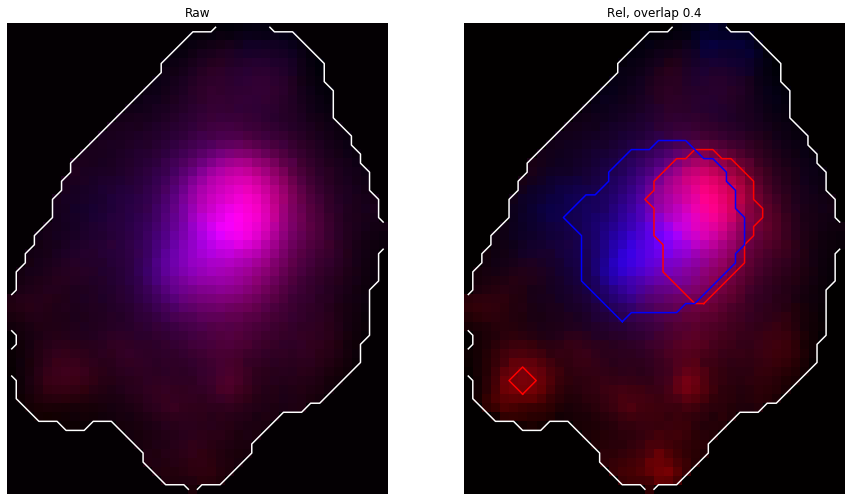

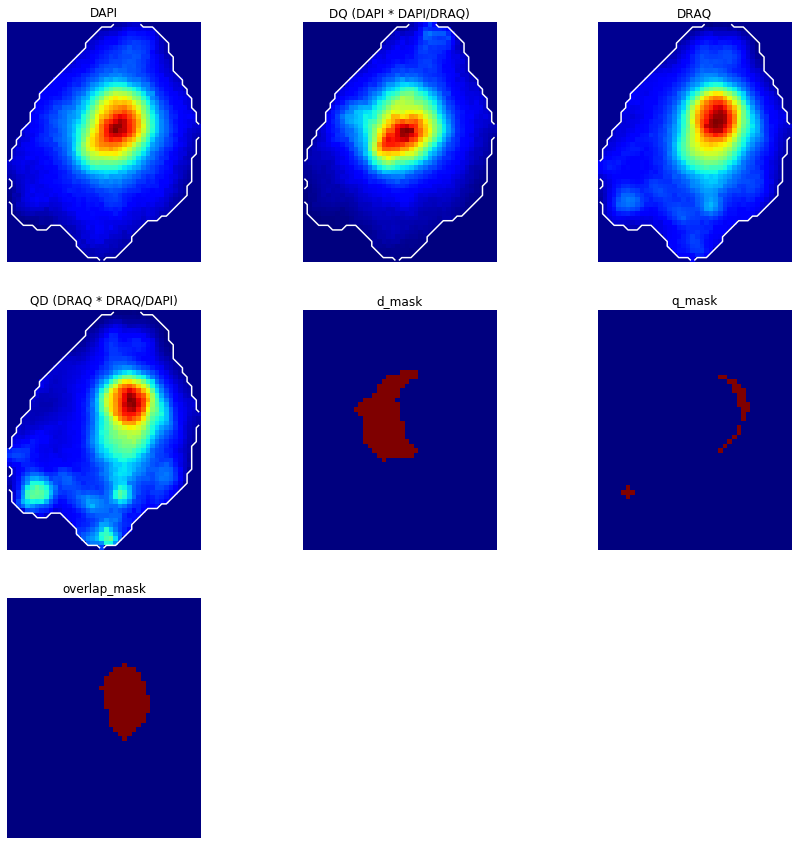

T/C/S:   S


fuck it
0.11746987951807229
nucleus/kDNA mean raw intensity 43456.934 32367.66
background+cytoplasm mean raw intensity
10546.76
nucleus mean normalised intensity 220244.99639423078  kDNA mean normalised intensity  61546.12930689102


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


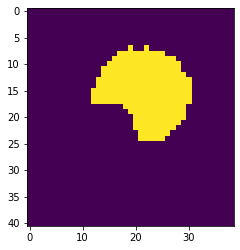

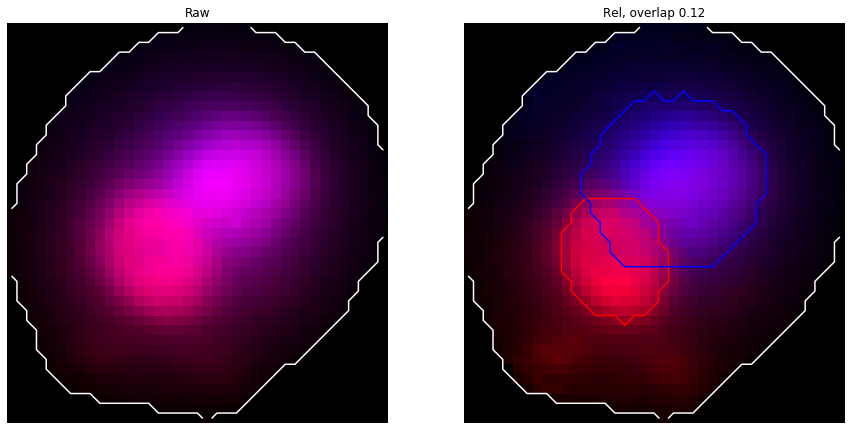

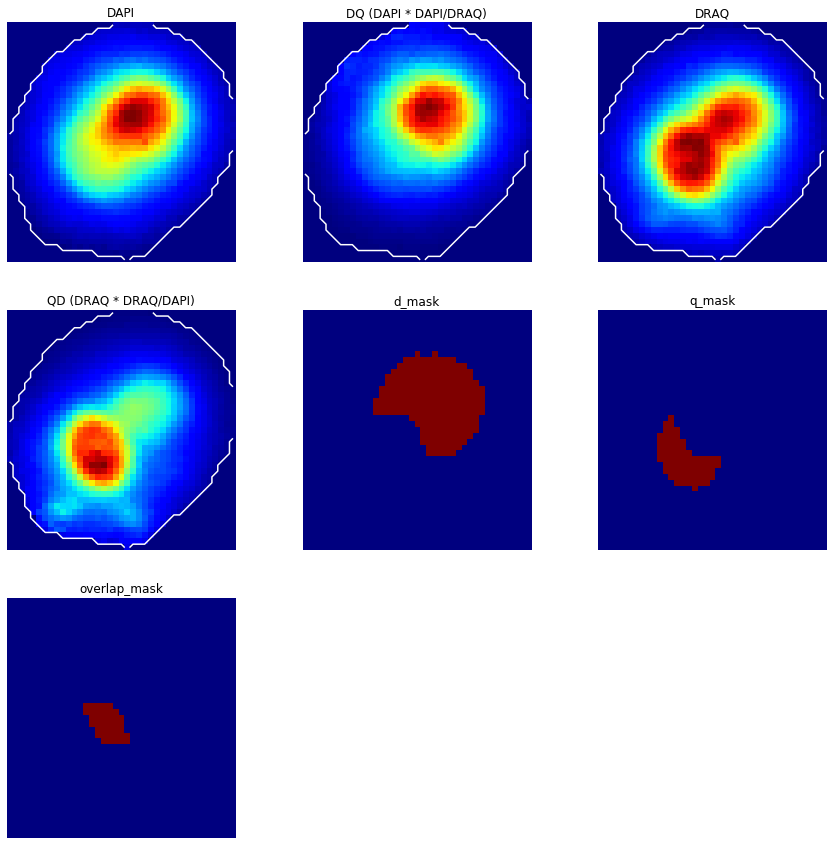

T/C/S:   S


fuck it
0.15810276679841898
nucleus/kDNA mean raw intensity 32690.275 23609.19
background+cytoplasm mean raw intensity
10108.34
nucleus mean normalised intensity 110086.93579101562  kDNA mean normalised intensity  27001.69921875


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


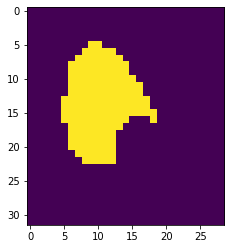

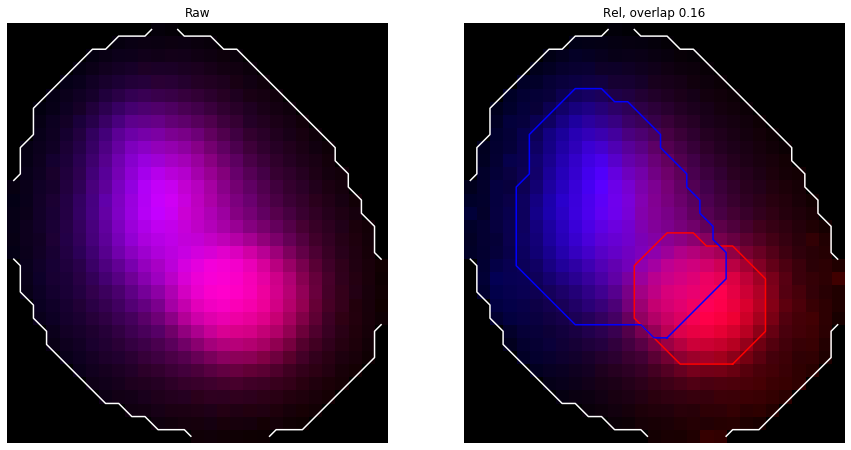

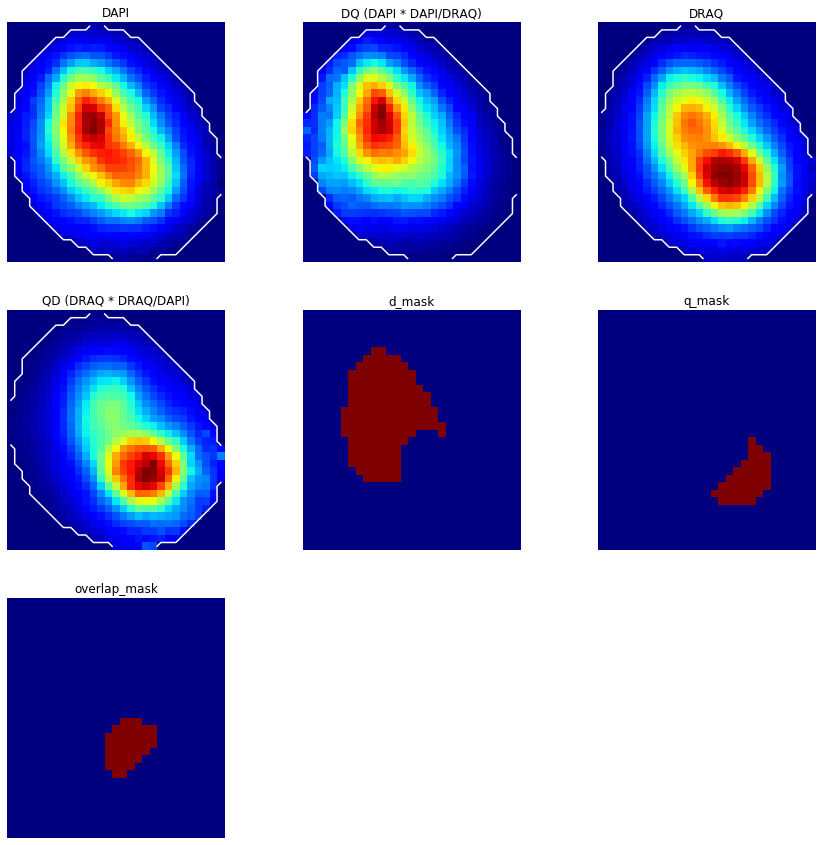

T/C/S:   


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.006872852233676976
nucleus/kDNA mean raw intensity 38684.1 30326.9
background+cytoplasm mean raw intensity
8247.24
nucleus mean normalised intensity 30436.861  kDNA mean normalised intensity  22079.66


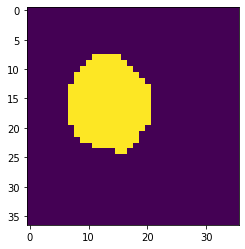

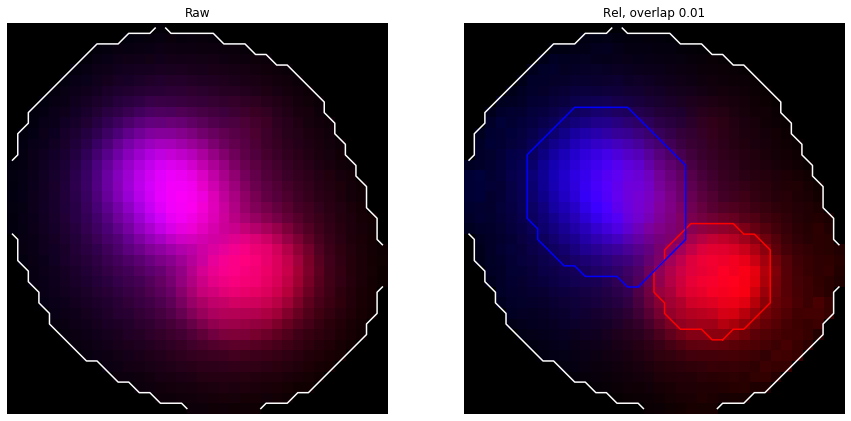

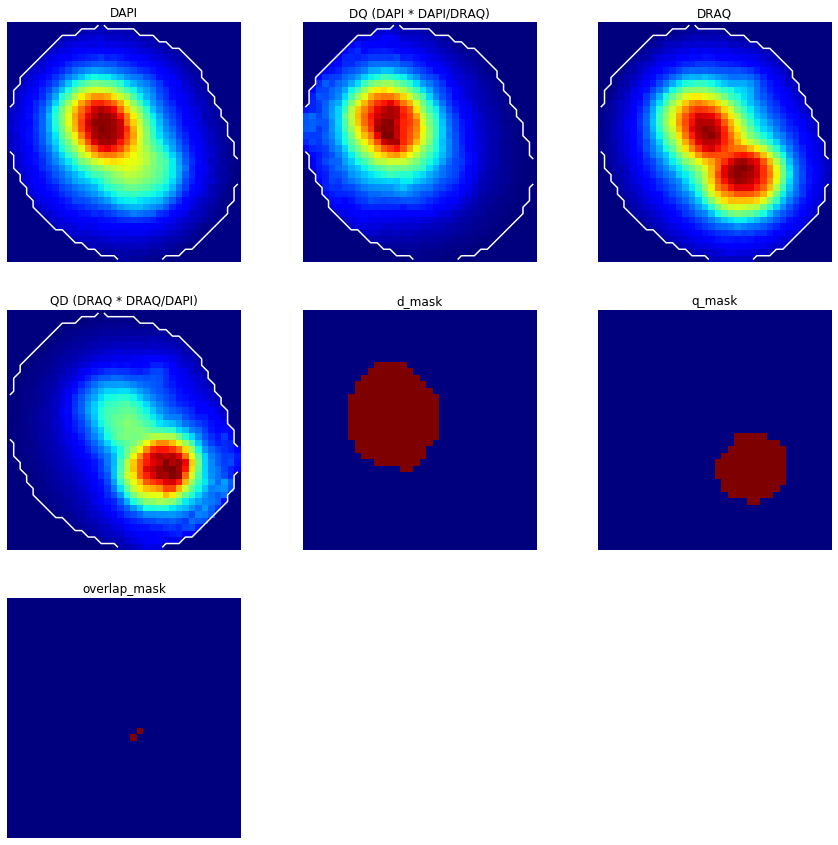

T/C/S:   


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.10309278350515463
nucleus/kDNA mean raw intensity 31545.33 21131.867
background+cytoplasm mean raw intensity
8832.202
nucleus mean normalised intensity 161263.215234375  kDNA mean normalised intensity  40588.894628906244


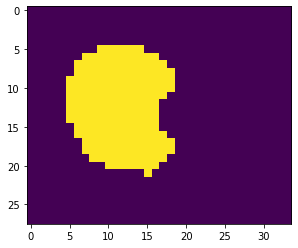

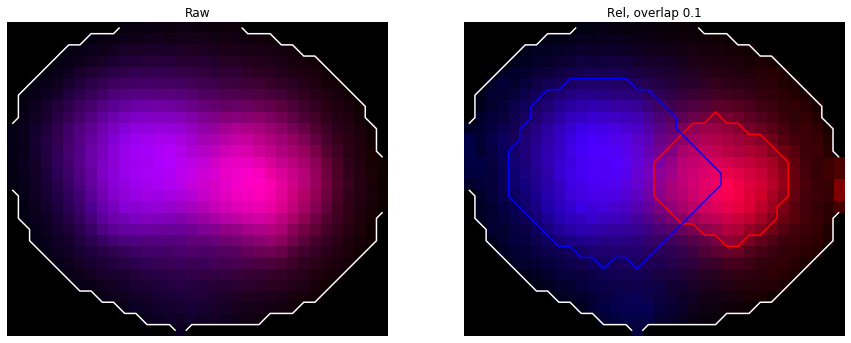

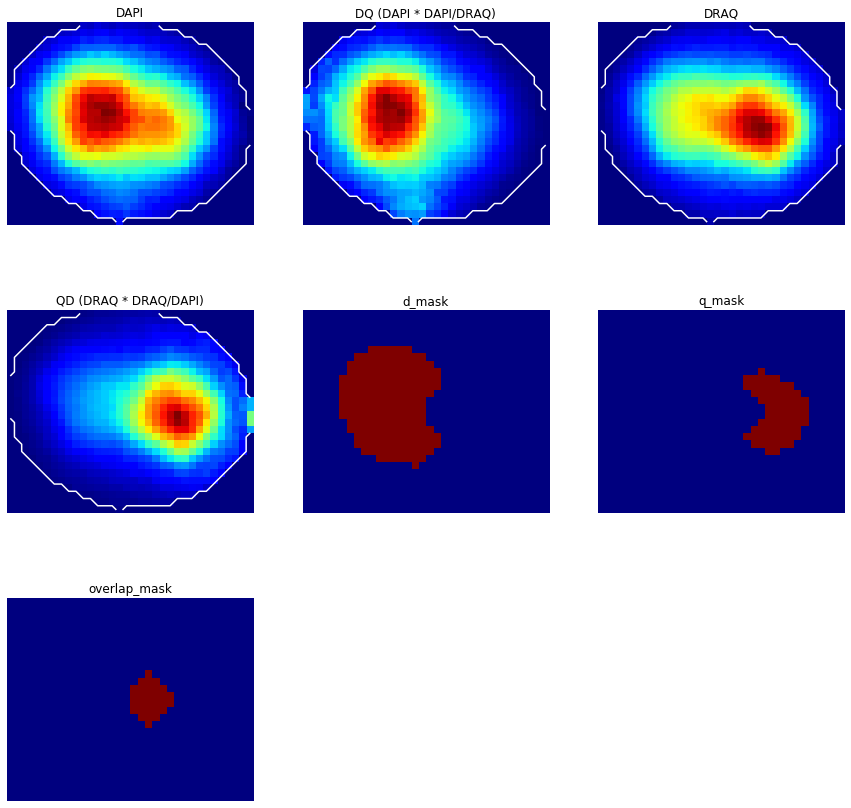

T/C/S:   


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.375
nucleus/kDNA mean raw intensity 37502.477 28188.557
background+cytoplasm mean raw intensity
9952.462
nucleus mean normalised intensity 66579.20442708334  kDNA mean normalised intensity  22035.279947916668


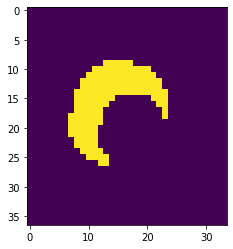

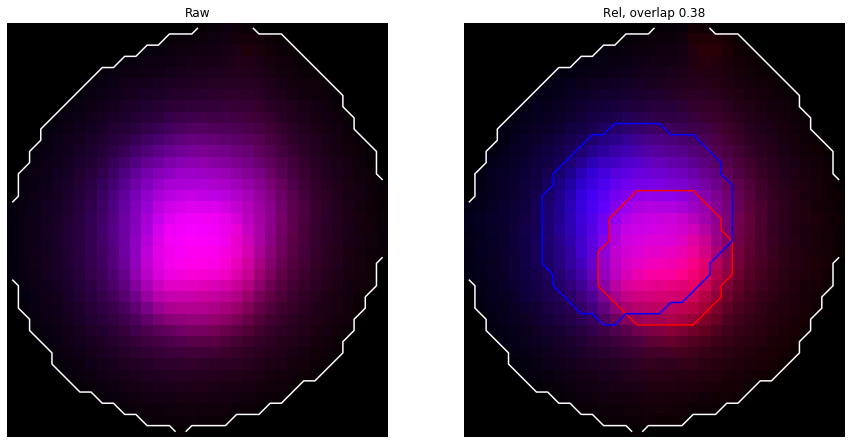

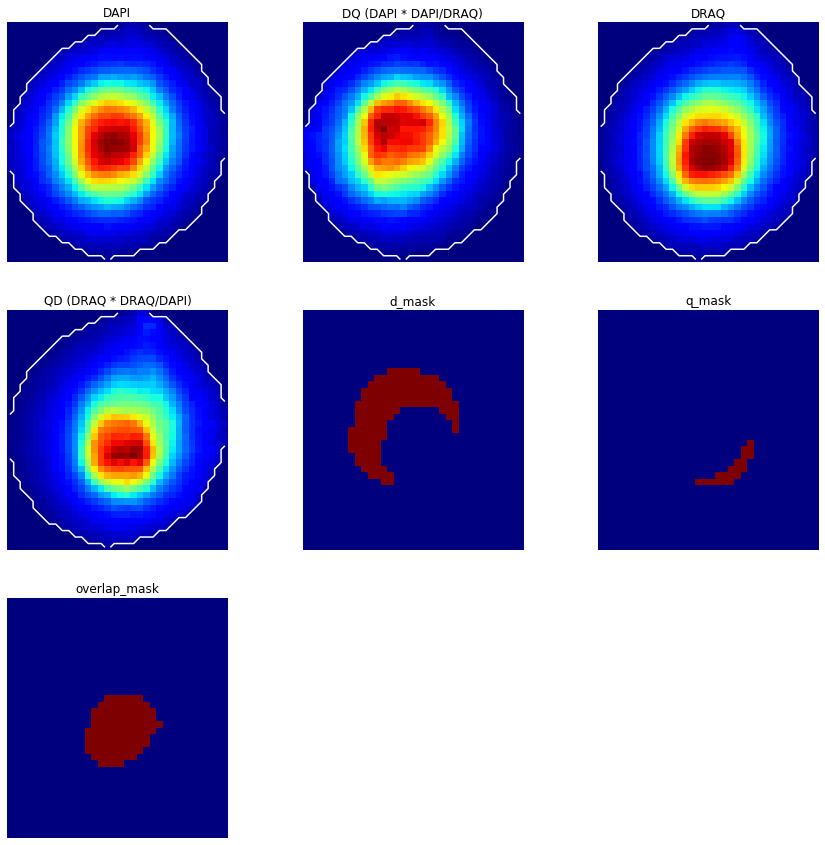

T/C/S:   


AttributeError: 'OneCell' object has no attribute 'calc_cell_parameters'

In [17]:
fin_out_df = pd.DataFrame(columns=['img_name',
                                   'num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])

for tiff in list_of_tiffs_annotated :
#######Reading image                            
    img_raw = io.imread("/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023/" + str(tiff))
    img_ch0 = img_raw[:,:,:,0]
    img_ch1 = img_raw[:,:,:,1]
    img_ch2 = img_raw[:,:,:,2]

    img_trans = np.mean(img_ch0, axis=0)
    img_dapi = np.sum(img_ch2, axis=0, dtype='int64')
    img_draq = np.sum(img_ch1, axis=0, dtype='int64')

    plt.figure(figsize=(20,20))
    plt.title(tiff, fontsize=10)
    
    ax0 = plt.subplot(132)
    ax0.imshow(img_dapi, cmap='jet')
    ax0.set_title('DAPI')
    ax0.axis('off')

    ax1 = plt.subplot(131)
    ax1.imshow(img_trans, cmap='Greys')
    ax1.set_title('trans')
    ax1.axis('off')

    ax2 = plt.subplot(133)
    ax2.imshow(img_draq, cmap='jet')
    ax2.set_title('Draq5')
    ax2.axis('off')

    plt.show()
##############Selecting cells
# masking by trans img
    img_trans_filt = filters.gaussian(img_trans, sigma=2)

    img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
    img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

    mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
    mask = ndi.binary_fill_holes(mask)
    mask = segmentation.clear_border(mask)

    mask = morphology.erosion(mask, footprint=morphology.disk(5))
    mask = morphology.dilation(mask, footprint=morphology.disk(4))
    
    labels, labels_num = ndi.label(mask)

# debris filtering
    ctrl_fluo_img = img_dapi + img_draq
    ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

    sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
    connected = sums > 0
    debris_mask = connected[labels]

# final mask filtering
    fin_trans_mask = np.copy(mask)
    fin_trans_mask[~debris_mask] = 0  # debris rejection
# fin_trans_mask[ctrl_fluo_mask] = 1  # holes filling with DAPI+DRAQ mask
# fin_trans_mask = segmentation.clear_border(fin_trans_mask)  # borders cleaning
# fin_trans_mask = morphology.opening(fin_trans_mask, footprint=morphology.disk(5))  # rejection of DAPI+DRAW mask artifacts
# fin_trans_mask = ndi.binary_fill_holes(fin_trans_mask)

    fin_fluo_mask = morphology.dilation(ctrl_fluo_mask, footprint=morphology.disk(4))
    fin_fluo_mask = segmentation.clear_border(fin_fluo_mask)
    fin_fluo_mask = morphology.opening(fin_fluo_mask, footprint=morphology.disk(6))  # rejection of DAPI+DRAW mask artifacts

    cells_labels, cells_num = ndi.label(fin_fluo_mask)


# plt.figure(figsize=(20,20))

# ax1 = plt.subplot()
# ax1.imshow(img_trans, cmap='Greys')
# ax1.imshow(ma.masked_where(~fin_trans_mask, cells_labels), cmap='jet', alpha=.5)
# ax1.imshow(ma.masked_where(~fin_fluo_mask, fin_fluo_mask), cmap='Greys', alpha=.4)
# ax1.imshow(ma.masked_where(debris_mask, ~debris_mask), cmap='magma', alpha=.75)
# ax1.axis('off')
# ax1.set_title(f'DNA-containing elements selection ({cells_num} cells)\nwhite - DAPI+DRAQ regions, black - debris',
#               fontsize=30)

# plt.tight_layout()
# plt.show()

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_trans, cmap='Greys')
    ax.set_axis_off()
    ax.set_title('Cells regions')

    #for each region, calculating parameters
    cells_list = []
    for region in measure.regionprops(cells_labels):
    #    if region.label == 1:  # uncomment for debug
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        some_cell = OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_fluo_mask[minr:maxr, minc:maxc])
        
        some_cell.pic_overlay()
        some_cell.pic_grid()
        check = input('T/C/S:  ')
        if check == 'S':
            print("fuck it")
            some_cell.cell_species = "Some_shit"
        elif check == 'C':
            cells_list.append(some_cell)
            some_cell.cell_species = "Control"
        elif check == 'T':
            cells_list.append(some_cell)
            some_cell.cell_species = "Test"      
        
        
    #demo_cell.pic_px_plot()

    for cell in cells_list:
        cell_df = cell.calc_cell_parameters()

        output_df = pd.concat([output_df, cell_df],
                               ignore_index=True)
    
    
  
    # Using 'Address' as the column name
    # and equating it to the list
    output_df['img_name'] = tiff
    
    
    fin_out_df = pd.concat([fin_out_df, output_df])
    fin_out_df.to_csv('/home/dzavadska/Data/kDNA/fluo_methods/scripts2024/run_outs_tmp/12012024_demo12012024_firstlooprun.csv')

